In [238]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from xgboost import XGBClassifier

In [251]:
df_train=pd.read_csv("train.csv",parse_dates=['date'], index_col='date')
df_test=pd.read_csv("test.csv",parse_dates=['date'], index_col='date')
df_train['month']=df_train.index.month
df_train['day']=df_train.index.day
df_test['month']=df_test.index.month
df_test['day']=df_test.index.day


In [252]:
df_train.head(5)

,warehouse_id,product_id,quantity,id,month,day
date,,,,,,
2020-12-02,0,71165,1,0,12,2
2020-12-03,0,71165,3,1,12,3
2020-12-07,0,71165,2,2,12,7
2020-12-08,0,71165,2,3,12,8
2020-12-09,0,71165,3,4,12,9


In [224]:
set1=set(df_train['product_id'])
set2=set(df_test['product_id'])
print(len(set1))
print(len(set1.intersection(set2)))

3288
3288


In [380]:
train=df_train[df_train['month']!=4].copy()
train.shape

(72196, 7)

In [381]:
val=df_train[df_train['month']==4].copy()
val.shape

(5871, 7)

In [438]:
train['label'] = 'train'
val['label'] = 'val'

df = pd.concat((train,val), axis = 0)
df['target'] = np.where(df.label == 'train', df.quantity, np.nan)
df.head(2)

,warehouse_id,product_id,quantity,id,month,day,label,target
date,,,,,,,,
2020-12-02,0,71165,1,0,12,2,train,1.0
2020-12-03,0,71165,3,1,12,3,train,3.0


In [471]:
def add_lags(tek_df):
    lag_period = 24
    features = []
    for period_mult in range(1,4,1):
        tek_df["lag_period_{}".format(period_mult)] = tek_df.quantity.shift(period_mult*lag_period)
        features.append("lag_period_{}".format(period_mult))

    tek_df['lagf_mean'] = tek_df[features].mean(axis = 1)
    tek_df['lagf_std'] = tek_df[features].std(axis = 1)
    features.extend(['lagf_mean'])
    features.extend(['lagf_std'])
    return tek_df,features


In [472]:
tek_df=df[df['product_id']==71165]
tek_df=tek_df[tek_df['warehouse_id']==0]
tek_df.label.unique()

array(['train', 'val'], dtype=object)

In [473]:
tek_df[tek_df['label']=='val']

,warehouse_id,product_id,quantity,id,month,day,label,target
date,,,,,,,,
2021-04-02,0,71165,2,91,4,2,val,NaN
2021-04-03,0,71165,7,92,4,3,val,NaN
2021-04-04,0,71165,4,93,4,4,val,NaN
2021-04-05,0,71165,2,94,4,5,val,NaN
2021-04-06,0,71165,6,95,4,6,val,NaN
2021-04-07,0,71165,2,96,4,7,val,NaN


In [474]:
tek_df,features=add_lags(tek_df)

In [475]:
tek_df.tail(10)

,warehouse_id,product_id,quantity,id,month,day,label,target,lag_period_1,lag_period_2,lag_period_3,lagf_mean,lagf_std
date,,,,,,,,,,,,,
2021-03-23,0,71165,2,87,3,23,train,2.0,1.0,2.0,1.0,1.333333,0.577350
2021-03-26,0,71165,1,88,3,26,train,1.0,1.0,5.0,2.0,2.666667,2.081666
2021-03-27,0,71165,2,89,3,27,train,2.0,1.0,6.0,1.0,2.666667,2.886751
2021-03-28,0,71165,9,90,3,28,train,9.0,2.0,6.0,2.0,3.333333,2.309401
2021-04-02,0,71165,2,91,4,2,val,NaN,1.0,16.0,3.0,6.666667,8.144528
2021-04-03,0,71165,7,92,4,3,val,NaN,4.0,6.0,5.0,5.000000,1.000000
2021-04-04,0,71165,4,93,4,4,val,NaN,2.0,1.0,1.0,1.333333,0.577350
2021-04-05,0,71165,2,94,4,5,val,NaN,4.0,2.0,2.0,2.666667,1.154701
2021-04-06,0,71165,6,95,4,6,val,NaN,3.0,2.0,3.0,2.666667,0.577350


In [476]:
model = LinearRegression()
tek_train_df = tek_df[tek_df.label == 'train'][features + ['target']].fillna(0)
tek_test_df = tek_df[tek_df.label == 'val'][features].fillna(0)

model.fit(tek_train_df.drop('target', axis = 1) ,tek_train_df['target'])
forecast = model.predict(tek_test_df)
tek_test_df['prediction'] = forecast




In [477]:
tek_test_df

,lag_period_1,lag_period_2,lag_period_3,lagf_mean,lagf_std,prediction
date,,,,,,
2021-04-02,1.0,16.0,3.0,6.666667,8.144528,1.290342
2021-04-03,4.0,6.0,5.0,5.000000,1.000000,4.656308
2021-04-04,2.0,1.0,1.0,1.333333,0.577350,3.208180
2021-04-05,4.0,2.0,2.0,2.666667,1.154701,3.538377
2021-04-06,3.0,2.0,3.0,2.666667,0.577350,3.911358
2021-04-07,3.0,2.0,1.0,2.000000,1.000000,3.228765


In [478]:
tek_df[tek_df['label']=='val']

,warehouse_id,product_id,quantity,id,month,day,label,target,lag_period_1,lag_period_2,lag_period_3,lagf_mean,lagf_std
date,,,,,,,,,,,,,
2021-04-02,0,71165,2,91,4,2,val,NaN,1.0,16.0,3.0,6.666667,8.144528
2021-04-03,0,71165,7,92,4,3,val,NaN,4.0,6.0,5.0,5.000000,1.000000
2021-04-04,0,71165,4,93,4,4,val,NaN,2.0,1.0,1.0,1.333333,0.577350
2021-04-05,0,71165,2,94,4,5,val,NaN,4.0,2.0,2.0,2.666667,1.154701
2021-04-06,0,71165,6,95,4,6,val,NaN,3.0,2.0,3.0,2.666667,0.577350
2021-04-07,0,71165,2,96,4,7,val,NaN,3.0,2.0,1.0,2.000000,1.000000


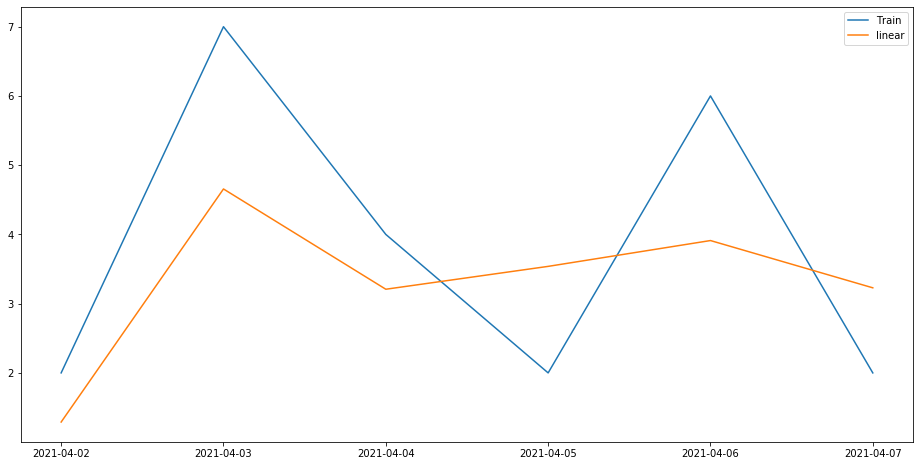

In [479]:
plt.figure(figsize=(16,8))
plt.plot(tek_df[tek_df['label']=='val'].quantity, label='Train')
plt.plot(tek_test_df.prediction, label='linear')
plt.legend(loc='best')
plt.show()

In [480]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(tek_df[tek_df['label']=='val'].quantity,tek_test_df.prediction))

2.47706307646397


In [ ]:
Это слишком много, но все же попробуем залить это в кэггл

In [481]:
df_test.shape

(46032, 6)

In [482]:
df_train['label'] = 'train'
df_test['label'] = 'test'

df = pd.concat((df_train,df_test), axis = 0,sort=True)
df['target'] = np.where(df.label == 'train', df.quantity, np.nan)
df.head(2)

,day,id,label,month,product_id,quantity,warehouse_id,target
date,,,,,,,,
2020-12-02,2,0,train,12,71165,1.0,0,1.0
2020-12-03,3,1,train,12,71165,3.0,0,3.0


In [483]:
otv_df=pd.DataFrame(columns=['id'])
otv_df.head(5)

,id


In [498]:
otv_df=pd.DataFrame(columns=['id'])
for tek_prod_id in tqdm(df_test['product_id'].unique()):
    for tek_store_id in [0,1]:
        tek_df=df[df['product_id']==tek_prod_id]
        tek_df=tek_df[tek_df['warehouse_id']==tek_store_id]
        
        tek_df,features=add_lags(tek_df)
        
        model = LinearRegression()
        tek_train_df = tek_df[tek_df.label == 'train'][features + ['target']].fillna(0)
        tek_test_df = tek_df[tek_df.label == 'test'][features].fillna(0)
        
        #print(tek_prod_id, tek_store_id,len(tek_train_df),len(tek_test_df))
        
        if (len(tek_train_df)>0):
            model.fit(tek_train_df.drop('target', axis = 1) ,tek_train_df['target'])
            forecast = model.predict(tek_test_df)
        else:
            forecast=np.zeros(len(tek_test_df))
        
        newt=tek_df[tek_df.label == 'test'].copy()[['id']]
        newt['prediction'] = forecast
        otv_df = pd.concat((otv_df,newt), axis = 0,sort=True)
        
    

otv_df.shape

100%|██████████| 3288/3288 [14:17<00:00,  3.97it/s]


(46032, 2)

In [499]:
df_test.shape

(46032, 6)

In [506]:
new_df=otv_df.copy()
new_df=new_df.sort_values(by=['id'])
new_df.rename(columns={'prediction':'quantity'},inplace=True)
new_df.head(5)

,id,quantity
2021-04-09,0,3.406182
2021-04-09,1,5.634655
2021-04-09,2,3.336207
2021-04-09,3,2.214286
2021-04-09,4,1.541667


In [507]:
new_df.to_csv("y_predTest.csv",index=False)